# Synthetic worm image generator

This notebook should result in the creation of a set of realistic but synthetic images (and ground-truth masks) of c. elegans worms.

### Imports

In [1]:
import numpy as np
from PIL import Image
import os
import cv2
import matplotlib.pyplot as plt
from copy import copy

## Pseudocode

load image

choose a mask

worm = pixels corresponding to this mask from originial image

apply transform to worm

apply transform to mask

insert transformed worm into original image

save image
save mask

### Functions


In [2]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 4)).astype(np.uint8)[:,:,:3]

In [3]:
def synthesise_worms(image_np, masks, scale=30, angle_scale=90):
    new_image = copy(image_np)

    for m in range(int(len(masks)/2)):

        shifts = [int(np.random.normal(scale=scale)),int(np.random.normal(scale=scale)),0]
        angle = np.random.normal(angle_scale)

        worm_mask = masks[m]
        worm_where = np.where(worm_mask)



        worm_center = tuple((int(np.mean(worm_where[1])), int(np.mean(worm_where[0]))))
        rot_mat = cv2.getRotationMatrix2D(worm_center, angle, 1.0)
        rotated_image = cv2.warpAffine(src=image_np, M=rot_mat, dsize=image_np.shape[:2], flags=cv2.INTER_LINEAR)
        rotated_mask = cv2.warpAffine(worm_mask, rot_mat, worm_mask.shape[:2], flags=cv2.INTER_LINEAR)
        rotated_where = np.where(rotated_mask)

        # new_image[rotated_where] = rotated_image[rotated_where]


        # worm_where_shifted = np.where(worm_mask)
        worm_where_shifted = np.where(rotated_mask)

        for i,j in zip(worm_where_shifted,shifts):
            if np.max(i+j) > image_np.shape[0] or np.min(i+j) < 0:
                pass
            else:
                i += j

        new_image[worm_where_shifted] = rotated_image[rotated_where]
        new_mask = np.zeros(masks[m].shape)
        new_mask[worm_where_shifted] = 255
        masks.append(new_mask)
    
    return new_image, masks


In [4]:
def plot_old_and_new(image_np, new_image, plot_masks=False, masks=None):
    w = 2
    if plot_masks:
        w = 3
    
    plt.figure(figsize=IMAGE_SIZE)

    plt.subplot(1,w,1)
    plt.imshow(image_np)

    plt.subplot(1,w,2)
    plt.imshow(new_image)

    if plot_masks:
        masks_array = np.asarray(masks)
        mask_sum = np.sum(masks_array, axis=3)
        mask_sum = np.sum(mask_sum, axis=0)
        plt.subplot(1,w,3)
        plt.imshow(mask_sum)
        
    plt.show()
    plt.close()

# Main body


## Define data

In [9]:
NUM_IMAGES = 1

# Size, in inches, of the output images.
IMAGE_SIZE = (30,30)


# PATH_TO_TEST_IMAGES_DIR = '/Users/daniel/Documents/UCL/Project/cropped_data/'
# PATH_TO_TEST_IMAGES_DIR = '/Users/daniel/Documents/UCL/Project/Data/annotation-data/cropped_collated_dataset/original_cropped_data/'
PATH_TO_TEST_IMAGES_DIR = '/Users/daniel/Documents/UCL/Project/Data_pre_exams/eval/'
# PATH_TO_TEST_IMAGES_DIR = '/Users/daniel/Documents/UCL/Project/Data/annotation-data/cropped_collated_dataset/CX11271_worms10_food1-10_Set1_Pos4_Ch4_19052017_113042/'
# PATH_TO_TEST_IMAGES_DIR = '/Users/daniel/Documents/UCL/Project/Data/annotation-data/cropped_collated_dataset/NIC199_worms10_food1-10_Set7_Pos4_Ch4_19052017_153012/'
# PATH_TO_TEST_IMAGES_DIR = '/Users/daniel/Documents/UCL/Project/Data/BBBC/BBBC_CURATED'



FNAMES = [f for f in os.listdir(PATH_TO_TEST_IMAGES_DIR) if not f.startswith('.')]
FNAMES = sorted(FNAMES)[:NUM_IMAGES] #, key=int)

# test_fname = FNAMES[0]

# print(list(np.random.choice(len(FNAMES), size=3, replace=False)))
# TEST_IMAGE_PATHS = [os.path.join(PATH_TO_TEST_IMAGES_DIR, '{}/image/image_{}.png'.format(i,i)) for i in FNAMES] # np.random.choice(len(FNAMES), size=NUM_IMAGES, replace=False)]

# TEST_IMAGE_PATH = os.path.join(PATH_TO_TEST_IMAGES_DIR, '{}/image/image_{}.png'.format(test_fname,test_fname))





## Perform data synthesis

Worms have a typical length of ~50 pixels. We will consider worms existing within a radius of this size of another worm as close

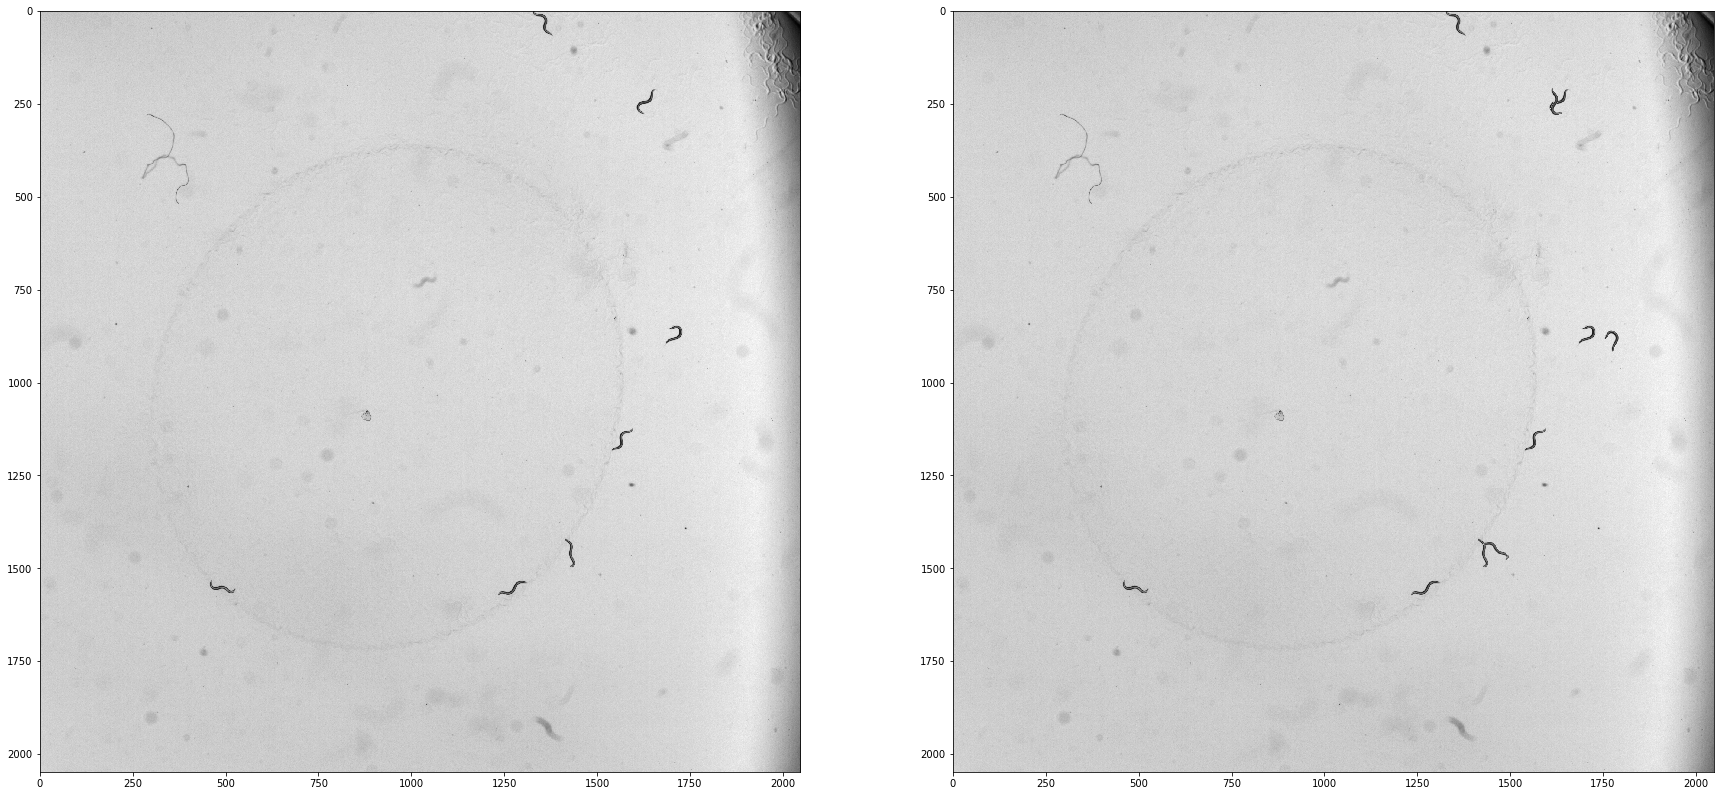

In [10]:
for fname in FNAMES:
    TEST_IMAGE_PATH = os.path.join(PATH_TO_TEST_IMAGES_DIR, '{}/image/image_{}.png'.format(fname,fname))
    image = Image.open(TEST_IMAGE_PATH)
    image_np = load_image_into_numpy_array(image)

    MASKS_DIR = os.path.join(PATH_TO_TEST_IMAGES_DIR, '{}/masks/'.format(fname))
    MASK_FNAMES = [f for f in os.listdir(MASKS_DIR) if not f.startswith('.')]

    masks = []
    for m in MASK_FNAMES:
        mask = Image.open(os.path.join(MASKS_DIR,m))
        masks.append(np.asarray(mask)[:,:,:3])
    
    syn_image, syn_masks = synthesise_worms(image_np, masks, scale=30, angle_scale=45)
    
    plot_old_and_new(image_np, syn_image, plot_masks=False, masks=None)
    